The basic idea behind the unscented Kalman Filter is incredibly simple. I'll break the reasoning down into 3 logical steps.

1. At each iteration, whatever the true state distribution looks like, we can just pretend it's Gaussian: ie we can parametrize it by just the mean and the variance. After all, we kind of do this in the vanilla Kalman filter because we know no physical state, process model or measurement function is truly Gaussian, but often times for linear problems the filter works reasonably well anyway.
2. Like with the idea of the particle filter, we can take large set of points randomly generated according to our initial state (in terms of the UKF we can call these "sigma points") distribution and use Monte Carlo to predict and update. We can then compute the covariance and mean of the resulting distribution of points. 
3. But it's really expensive to do Monte Carlo, especially in higher dimensions were we need more points to get a smooth distribution. Rather than randomly sampling lots of sigma points, could we be somehow clever about sampling just a few sigma points in such a way that the resulting mean and standard deviation of the transformed points is close to the true values? Yes we can. There are several schemes for selecting sigma points.

Here's an illustration of points 2 and 3 in action:

![](.images/2022-08-24-17-10-05.png)

A nonlinear function transforms the randomly samples points of a 2D guassian (left) to get a new non-gaussian distribution (right). The blue star is the mean of the many points. The red points on the left are Merwe Scaled sigma points (points selected by one well known scheme. The red triangle (right) is the mean of the transformed sigma points and it happens to be fairly close to the "true" mean.

### The predict step

I missed a detail about how the mean and covariance are computed from the transformed sigma points. In fact, the sigma point selection scheme also has a set of weights for computing the mean, and another set of weights for computing the covariance.

For a particular scheme we have that the sigma points are $\mathbf{\chi}$, weights for computing the mean are $W^m$ and weights for computing the covariance are $W^c$.

The sigma points are projected forward by the process model $\mathbf{\mathcal{Y}} = f(\mathbf{\chi}, \Delta t)$. The mean and covariance of the prior for the state are then:

$$
\mathbf{\bar{x}} = \sum_{i=0}^{2n} w^m_i * \mathbf{\mathcal{Y}_i}
$$

and

$$
\mathbf{\bar{P}} = \sum_{i=0}^{2n} w^c_i * (\mathbf{\mathcal{Y}_i} - \mathbf{\bar{x}})(\mathbf{\mathcal{Y}_i} - \mathbf{\bar{x}}) ^\intercal + \mathbf{Q}
$$

where $n$ is the dimensionality of $\mathbf{x}$ ($2n+1$ sigma points are generated). We add the $\mathbf{Q}$ the same way we do for the linear KF and with the same justification that the sum of two gaussian variables is effectively sampled from another gaussian distribution where the covariances and means are summed.

### The update step

First we further transform the sigma points according to the measurement function: $\mathbf{\mathcal{Z}} = h(\mathbf{\mathcal{Y}})$. Then we apply the unscented transform to compute the mean and covariance of these points:

$$
\mathbf{\mu_z} = \sum_{i=0}^{2n} w^m_i * \mathbf{\mathcal{Z}_i}
$$

and

$$
\mathbf{P_z} = \sum_{i=0}^{2n} w^c_i * (\mathbf{\mathcal{Z}_i} - \mathbf{\mu_z})(\mathbf{\mathcal{Z}_i} - \mathbf{\mu_z}) ^\intercal + \mathbf{Q} + R
$$

The residual is then $\mathbf{y} = \mathbf{z} - \mathbf{\mu_z}$. $\mathbf{P_z}$ is conceptually like the "system uncertainty" from the vanilla KF.

I get lost in the next steps and the author even says that I need to take them on faith, but for some reason the Kalman gain is then computed as:

$$
\mathbf{K} = \mathbf P_{xz} \mathbf P_z^{-1}
$$

where

$$
\mathbf P_{xz} =\sum_{i=0}^{2n} w^c_i(\boldsymbol{\mathcal Y}_i-\mathbf{\bar x})(\boldsymbol{\mathcal Z}_i-\boldsymbol\mu_z)^\mathsf T
$$

Finally, the new covariance is computed as:

$$
\mathbf P = \mathbf{\bar P} - \mathbf{KP_z}\mathbf{K}^\intercal
$$

**Overall** here's a comparison table between KF and UKF:

This table compares the equations of the linear KF and UKF equations.

$$\begin{array}{l|l}
\textrm{Kalman Filter} & \textrm{Unscented Kalman Filter} \\
\hline 
& \boldsymbol{\mathcal Y} = f(\boldsymbol\chi) \\
\mathbf{\bar x} = \mathbf{Fx} & 
\mathbf{\bar x} = \sum w^m\boldsymbol{\mathcal Y}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf T+\mathbf Q  & 
\mathbf{\bar P} = \sum w^c({\boldsymbol{\mathcal Y} - \mathbf{\bar x})(\boldsymbol{\mathcal Y} - \mathbf{\bar x})^\mathsf T}+\mathbf Q \\
\hline 
& \boldsymbol{\mathcal Z} =  h(\boldsymbol{\mathcal{Y}}) \\
& \boldsymbol\mu_z = \sum w^m\boldsymbol{\mathcal{Z}} \\
\mathbf y = \mathbf z - \mathbf{Hx} &
\mathbf y = \mathbf z - \boldsymbol\mu_z \\
\mathbf S = \mathbf{H\bar PH}^\mathsf{T} + \mathbf R & 
\mathbf P_z = \sum w^c{(\boldsymbol{\mathcal Z}-\boldsymbol\mu_z)(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}} + \mathbf R \\ 
\mathbf K = \mathbf{\bar PH}^\mathsf T \mathbf S^{-1} &
\mathbf K = \left[\sum w^c(\boldsymbol{\mathcal Y}-\bar{\mathbf x})(\boldsymbol{\mathcal{Z}}-\boldsymbol\mu_z)^\mathsf{T}\right] \mathbf P_z^{-1} \\
\mathbf x = \mathbf{\bar x} + \mathbf{Ky} & \mathbf x = \mathbf{\bar x} + \mathbf{Ky}\\
\mathbf P = (\mathbf{I}-\mathbf{KH})\mathbf{\bar P} & \mathbf P = \bar{\mathbf P} - \mathbf{KP_z}\mathbf{K}^\mathsf{T}
\end{array}$$

For my summary here, I don't want to go into the precise details of sigma point selection schemes. One example presented is Van der Merwe's Scaled Sigma Point Algorithm. It takes 3 parameters: $\alpha$, $\beta$, and $\kappa$, chooses one sigma point to be the mean of the input gaussian, and the other 3 to be arranged around the means as scaled by the square root of the covariance matrix further scaled by two of the parameters:

$$ 
\boldsymbol{\chi}_i = \begin{cases}
\mu + \left[ \sqrt{(\alpha^2(n+\kappa))\Sigma}\right ]_{i}& i=1..n \\
\mu - \left[ \sqrt{(\alpha^2(n+\kappa))\Sigma}\right]_{i-n} &i=(n+1)..2n\end{cases}
$$

The author talks about some ways we can think of what the different parameters do. Van Der Merwe's paper is also a good place to look. But I'll leave it at that for these notes.

As an exercise I am going to go through the robot localization code and rewrite it myself. Consult the book for the modelling equations.

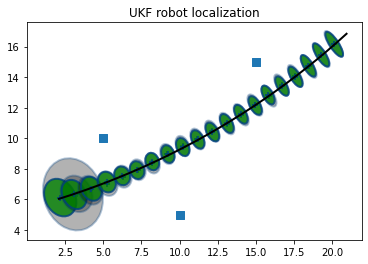

Final P: [0.00934551 0.01850131 0.00070039]


In [37]:
import math
from turtle import update

import numpy as np


def move(x, dt, u, wheelbase):
    """ Takes a state x, a time step dt, a control input u, and a wheelbase distance, and returns the updated state
    x is [x_position, y_position, theta]
    """
    alpha = u[1]  # steering angle
    v = u[0]  # forward velocity
    d = dt * v  # distance moved in small timestep

    xbar = x.copy()
    if abs(alpha) > 0.001:
        beta = d / wheelbase * math.tan(alpha)  # steering angle
        R = d / beta  # turning radius

        # Update the x postition.
        xbar[0] = x[0] - R * math.sin(x[2]) + R * math.sin(x[2] + beta)
        # Update the y position.
        xbar[1] = x[1] + R * math.cos(x[2]) - R * math.cos(x[2] + beta)
        # Update the orientation.
        xbar[2] = x[2] + beta
    else:
        # Update the x postition.
        xbar[0] = x[0] + d * math.cos(x[2])
        # Update the y position.
        xbar[1] = x[1] + d * math.sin(x[2])
        # No need to update theta as we are not turning.

    return xbar


def canonicalize_angle(angle):
    """ Take an angle in radians it put it into the range [-pi, pi). Return the result. """
    while angle >= math.pi:
        angle -= 2 * math.pi
    while angle < -math.pi:
        angle += 2 * math.pi
    return angle


def Hx(x, landmarks):
    """ Measurement function.
    Given a state, get what the distance and bearing would be to each of the landmarks. A landmark is specified by
    a (x_position, y_position) tuple. The bearing is shifted to be in the [-pi, pi) range.
    The output will be a 1D array of size 2 * num landmarks.
    """
    z = []
    for landmark in landmarks:
        xdist = landmark[0] - x[0]
        ydist = landmark[1] - x[1]
        distance = math.sqrt(xdist**2 + ydist**2)
        # NOTE: -x[2] because we are considering the bearing in the reference frame of the vehicle.
        bearing = canonicalize_angle(math.atan2(ydist, xdist) - x[2])
        z.extend([distance, bearing])

    return np.array(z)


def x_mean(sigmas, Wm):
    """ Compute the weighted mean of states.
    For the bearing component of the states this is not trivial. The idea is to take the mean of the cartesian
    components of the bearings and arctan that.
    Args:
        sigmas: (7, 3) array of sigma points, each row being a single sigma point in the 3-dimensional state space.
        Wm: (7,) array of weights for the unscented transform.
    Returns:
        (3,) array representing the mean of the prior state distribution.
    """
    x = np.zeros(3)  # (x_position, y_position, theta)
    # Normal weighted mean for x position.
    x[0] = np.dot(sigmas[:, 0], Wm)
    # Normal weighted mean for y position.
    x[1] = np.dot(sigmas[:, 1], Wm)
    # Special weigthed mean for bearing.
    x[2] = math.atan2(
        np.dot(np.sin(sigmas[:, 2]), Wm),  # weighted sum of x-component of bearing
        np.dot(np.cos(sigmas[:, 2]), Wm),  # weighted sum of y-component of bearing 
    )
    return x


def z_mean(sigmas, Wm):
    """ Compute the weighted mean of measurements.
    For the bearing component of the measurements this is not trivial. The idea is to take the mean of the cartesian
    components of the bearings and arctan that.
    Args:
        sigmas: (7, 2*N) array of sigma points. N is the number of visible landmarks. Each pair of a row in the array
            represents the distance and bearing of a landmark.
        Wm: (7,) array of weights for the unscented transform.
    Returns:
        (2*N,) array representing the mean if the measurements.
    """
    z = np.zeros(sigmas.shape[1])  # (distance, bearing)
    z[0::2] = (sigmas[:, 0::2] * Wm[:, None]).sum(0)
    z[1::2] = np.arctan2(
        (np.sin(sigmas[:, 1::2]) * Wm[:, None]).sum(0),
        (np.cos(sigmas[:, 1::2]) * Wm[:, None]).sum(0)
    )
    return z


def residual_z(z, h_xbar):
    """
    Compute residual between a measurement and a state prior projectec into the measurement space.
    """
    y = z - h_xbar
    y[1::2] = np.array([canonicalize_angle(angle) for angle in y[1::2]])
    return y


def residual_x(x1, x2):
    """
    Compute difference between one state and another. NOTE: Roger Labbe calls this function residual_x for some reason.
    As far as I'm aware, there's only one "residual" and that's the measurement residual. Although in the Kalman filter
    math, subtracting one state from another happens often for computing covariances, I never noticed Roger Labbe
    calling it a residual.
    """
    x = x1 - x2
    x[2] = canonicalize_angle(x[2])
    return x


from filterpy.stats import plot_covariance_ellipse
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman.UKF import UnscentedKalmanFilter
import matplotlib.pyplot as plt

dt = 1 # Time step for the kf.
wheelbase = 0.5

def run_localization(
        cmds, landmarks, sigma_vel, sigma_steer, sigma_range, sigma_bearing, ellipse_step=1, step=10):
    """ Simulation implementation with filter implementation and plotting.
    The simulation will run through all of the command inputs. The filter will be applied on every `step` simulation
    steps.
    Args:
        cmds (np.ndarray): (*, 2) array of control commands as (velocity, steering angle) tuples.
        landmarks (np.ndarray): (N, 2) array with N being the number of landmarks. Each row represents the x-y co-
            ordinates of a landmark.
        sigma_range (float): Standard deviation of range measurements.
        sigma_bearing (float): Standard deviation of bearing measurements.
        ellipse_step (int): This many simulation steps elapse between plotting the covariance ellipse.
        step (int): This many simulation steps elapse between filter updates. So this divides the filter dt.
    """
    plt.figure()
    points = MerweScaledSigmaPoints(n=3, alpha=1e-5, beta=2, kappa=0., subtract=residual_x)
    ukf = UnscentedKalmanFilter(
        dim_x=3, dim_z=2*len(landmarks), dt=dt, hx=Hx, fx=move, points=points, x_mean_fn=x_mean,
        z_mean_fn=z_mean, residual_x=residual_x, residual_z=residual_z)

    ukf.x = np.array([2, 6, .3])
    ukf.P = np.diag([.1, .1, .05])
    ukf.R = np.diag([sigma_range**2, sigma_bearing**2]*len(landmarks))
    ukf.Q = np.eye(3) * 1e-4

    sim_pos = ukf.x.copy()

    # Plot landmarks.
    if len(landmarks) > 0:
        plt.scatter(landmarks[:, 0], landmarks[:, 1], marker='s', s=60)

    track = []
    for i, u in enumerate(cmds):
        sim_pos = move(sim_pos, dt / step, u, wheelbase)
        track.append(sim_pos)

        if i % step == 0:
            ukf.predict(u=u, wheelbase=wheelbase)  # wheelbase is passed to fx

            # Plot an ellipse representing the predicted prior.
            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[:2, :2], std=6, facecolor='k', alpha=0.3)

            # Generate a noisy measurement
            x, y = sim_pos[0], sim_pos[1]
            z = []
            for landmark in landmarks:
                dx, dy = landmark[0] - x, landmark[1] - y
                d = math.sqrt(dx**2 + dy**2) + np.random.randn()*sigma_range
                bearing = math.atan2(landmark[1] - y, landmark[0] - x)
                a = (canonicalize_angle(bearing - sim_pos[2] + np.random.randn()*sigma_bearing))
                z.extend([d, a])            
            ukf.update(z, landmarks=landmarks)

            # Plot an ellipse representing the posterior after measurement.
            if i % ellipse_step == 0:
                plot_covariance_ellipse((ukf.x[0], ukf.x[1]), ukf.P[:2, :2], std=6, facecolor='g', alpha=0.8)

    track = np.array(track)
    plt.plot(track[:, 0], track[:, 1], color='k', lw=2)
    plt.axis('equal')
    plt.title("UKF robot localization")
    plt.show()

    return ukf


# Now let's run it!
landmarks = np.array([[5, 10], [10, 5], [15, 15]])
cmds = [np.array([1.1, .01])] * 200
ukf = run_localization(cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1), sigma_range=0.3, sigma_bearing=0.1)
print("Final P:", ukf.P.diagonal())

# Comment to self: Notice how the ellipses start pancaking at the end of the trajactory. This is because all the
# landmarks are then to the lower left side of the car, so the interesctions of their measurement distributions overlap
# in a not so complementary way.

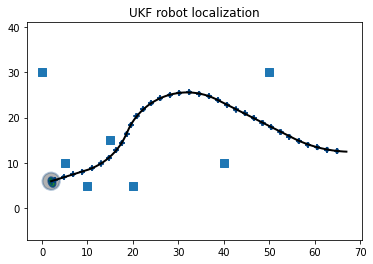

final covariance [0.00125204 0.0043089  0.00043589]


In [39]:
# A more fun example with steering involved

landmarks = np.array([[5, 10], [10, 5], [15, 15], [20, 5],
                      [0, 30], [50, 30], [40, 10]])
dt = 0.1
wheelbase = 0.5
sigma_range=0.3
sigma_bearing=0.1

def turn(v, t0, t1, steps):
  return [[v, a] for a in np.linspace(
                 np.radians(t0), np.radians(t1), steps)]  
    
# accelerate from a stop
cmds = [[v, .0] for v in np.linspace(0.001, 1.1, 30)]
cmds.extend([cmds[-1]]*50)

# turn left
v = cmds[-1][0]
cmds.extend(turn(v, 0, 2, 15))
cmds.extend([cmds[-1]]*100)

#turn right
cmds.extend(turn(v, 2, -2, 15))
cmds.extend([cmds[-1]]*200)

cmds.extend(turn(v, -2, 0, 15))
cmds.extend([cmds[-1]]*150)

cmds.extend(turn(v, 0, 1, 25))
cmds.extend([cmds[-1]]*100)


ukf = run_localization(
    cmds, landmarks, sigma_vel=0.1, sigma_steer=np.radians(1), sigma_range=0.3, sigma_bearing=0.1, step=1,
    ellipse_step=20)
print('final covariance', ukf.P.diagonal())

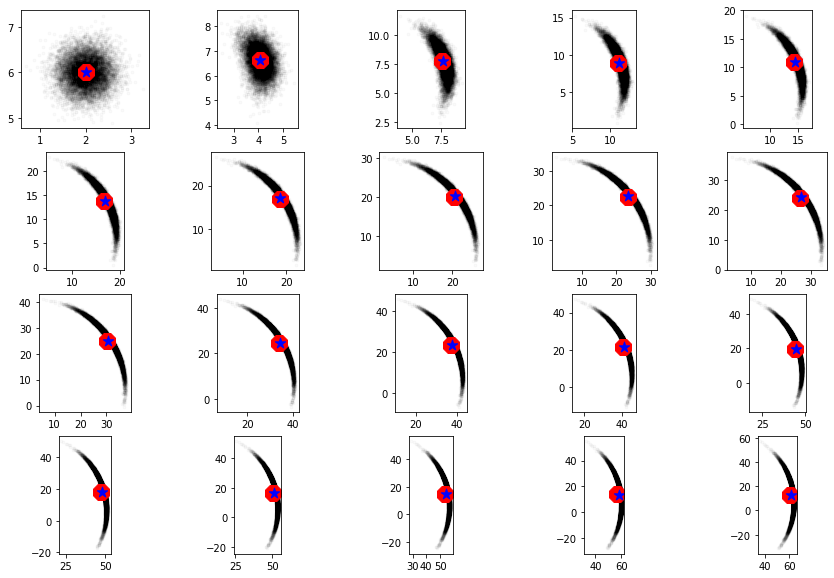

In [63]:
# I'm interested to see how a sampled gaussian is updated by the move function. I'll look at just the first two state dimensions
from numpy.random import multivariate_normal
from kf_book.nonlinear_plots import plot_bivariate_colormap


def f(xs, ys, bs, cmd):
    fxs = []
    fys = []
    fbs = []
    for x, y, b in zip(xs, ys, bs):
        fx, fy, fb = move([x, y, b], dt, cmd, wheelbase)
        fxs.append(fx)
        fys.append(fy)
        fbs.append(fb)
    return np.array(fxs), np.array(fys), np.array(fbs)

points = MerweScaledSigmaPoints(n=3, alpha=1e-5, beta=2, kappa=0., subtract=residual_x)
ukf = UnscentedKalmanFilter(
    dim_x=3, dim_z=2*len(landmarks), dt=dt, hx=Hx, fx=move, points=points, x_mean_fn=x_mean,
    z_mean_fn=z_mean, residual_x=residual_x, residual_z=residual_z)

ukf.x = np.array([2, 6, .3])
ukf.P = np.diag([.1, .1, .05])
ukf.R = np.diag([sigma_range**2, sigma_bearing**2]*len(landmarks))
ukf.Q = np.eye(3) * 1e-4

N = 10000

fig, ax = plt.subplots(4, 5, figsize=(15, 10))
ax = ax.flatten()

xs, ys, bs = multivariate_normal(
    mean=(2., 6., .3), cov=np.array([[0.1, 0., 0.], [0., 0.1, 0.], [0., 0., .05]]), size=N).T


steps_per_plot = 35
for i in range(len(ax)):
    ax[i].scatter(xs, ys, marker='.', alpha=0.02, color='k');
    ax[i].scatter(ukf.x[0], ukf.x[1], marker='8', s=300, c='r')
    ax[i].scatter(xs.mean(), ys.mean(), marker='*',s=120, c='b')
    ax[i].set_aspect('equal', 'box')
    for j in range(steps_per_plot):
        xs, ys, bs = f(xs, ys, bs, cmds[i*steps_per_plot + j])
        ukf.predict(u=cmds[i*steps_per_plot + j], wheelbase=wheelbase)
        